In [269]:
import datetime
import pandas as pd
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore
from firebase_admin import storage
from datetime import date, timedelta
import urllib.request, json 
import time
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import os

In [2]:
cred = credentials.Certificate("serene-2dfd6-firebase-adminsdk-gfc6o-a312184978.json")
app = firebase_admin.initialize_app(cred ,  {
    'storageBucket': 'serene-2dfd6.appspot.com',
}, name='storage')
db = firestore.client()

ValueError: The default Firebase app does not exist. Make sure to initialize the SDK by calling initialize_app().

In [248]:
# get from app 
duration = 2
userID = "UqTdL3T7MteuQHBe1aNfSE9u0Na2"

## Generate unique ID

In [257]:
# generate report unique ID
today = datetime.datetime.now()
timestamp = today.strftime("%Y-%m-%d %H:%M:%S")
reportId = userID +" "+ timestamp
reportId = reportId.replace(" ","_")

In [ ]:
# write to a collection 
doc_ref = db.collection(u'LastGeneratePatientReport').document('tt')
doc_ref.set({
    u'name':'raghad from python',
    u'age':'21'
})

In [9]:
# store to firebase storage 
bucket = storage.bucket(app=app)
imagePath = "image.png"
imageBlob = bucket.blob("7KXzpejWaRgyuZG9zcKttgaKd002/DoctorReport/python_img")
imageBlob.upload_from_filename(imagePath)

## get list of included dates  

In [249]:
#get a a list of date between start and end date 
dates =[]
for x in range(0 ,duration):
    start_date = (date.today()-timedelta(days=duration-x)).isoformat()
    dates.append(start_date)

## Generate a compelete DF

In [250]:
df= pd.DataFrame()
# loop through the storage and get the data
sleep =[]
for x in range(0 ,len(dates)):
    blob = bucket.blob(userID+"/fitbitData/"+dates[x]+"/"+dates[x]+"-sleep.json")
    # download the file 
    u = blob.generate_signed_url(datetime.timedelta(seconds=300), method='GET')
    with urllib.request.urlopen(u) as url:
        data = json.loads(url.read().decode())
        sleepMinutes = data['summary']["totalMinutesAsleep"]
    #steps 
    blob = bucket.blob(userID+"/fitbitData/"+dates[x]+"/"+dates[x]+"-activity.json")
    u = blob.generate_signed_url(datetime.timedelta(seconds=300), method='GET')
    with urllib.request.urlopen(u) as url:
        data = json.loads(url.read().decode())
        steps = data['goals']['steps']  
    #heartrate
    blob = bucket.blob(userID+"/fitbitData/"+dates[x]+"/"+dates[x]+"-heartrate.json")
    u = blob.generate_signed_url(datetime.timedelta(seconds=300), method='GET')
    with urllib.request.urlopen(u) as url:
        data = json.loads(url.read().decode())
        df_heartrate = pd.DataFrame(data['activities-heart-intraday']['dataset'])
    df_heartrate.time.apply(str)
    df_heartrate['time'] = pd.to_datetime(df_heartrate['time'])
    df_heartrate['hour'] = df_heartrate['time'].apply(lambda time: time.strftime('%H'))
    df_heartrate.drop(['time'],axis=1, inplace = True)
    heart_rate = df_heartrate.groupby(["hour"], as_index=False).mean()
    heart_rate['steps'] = steps
    heart_rate['sleep'] = sleepMinutes
    heart_rate['date'] = dates[x]
    heart_rate = heart_rate.astype({"hour": int})  
    # append dataframe
    df = df.append(heart_rate, ignore_index = True)

# Plot

## HR

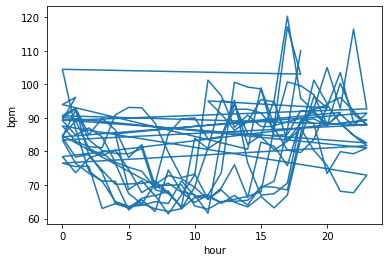

<Figure size 432x288 with 0 Axes>

In [251]:
# plot HR
fig1 = plt.gcf()
plt.plot(df['hour'], df['value'])
plt.xlabel('hour')
plt.ylabel('bpm')
plt.show()
plt.draw()
fig1.savefig('hr.png', dpi=100)
# store HR to firebase
imagePath = "hr.png"
imageBlob = bucket.blob(userID+"/DoctorReport/heartrate")
imageBlob.upload_from_filename(imagePath)
os.remove("hr.png")

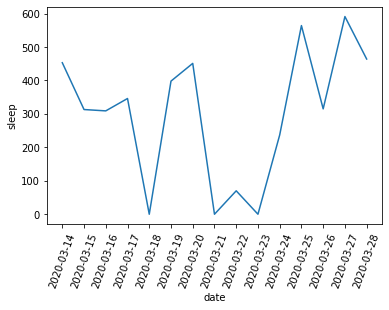

<Figure size 432x288 with 0 Axes>

In [276]:
# plot Sleep
# max plot a 15 date only 
fig1 = plt.gcf()
plt.plot(df['date'], df['sleep'])
plt.xlabel('date')
plt.ylabel('sleep')
plt.tick_params(axis='x', rotation=70)
plt.show()
plt.draw()
fig1.savefig('sleep.png', dpi=100)
# store HR to firebase
imagePath = "sleep.png"
imageBlob = bucket.blob(userID+"/DoctorReport/sleep")
imageBlob.upload_from_filename(imagePath)
#os.remove("sleep.png")

In [ ]:
# test Test